In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip -q install pyLDAvis

     |████████████████████████████████| 1.7 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


Word2Vec & Topic Modelling on Reviews Text Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import nltk, re
import seaborn as sns
import string
import os, gc
import random

tqdm.pandas()

base_dir = "/content/drive/Shareddrives/602Project/Assigns"
os.listdir(base_dir)

['dataset.zip',
 'imdb_movies_raw.csv.gz',
 'imdb_reviews_raw.csv.gz',
 'word2vec.gensim',
 'lda.gensim.state',
 'lda.gensim',
 'lda.gensim.expElogbeta.npy',
 'lda.gensim.id2word',
 'imdb_movies_train.csv.gz',
 'imdb_reviews_train.csv.gz',
 'imdb_movies_val.csv.gz',
 'imdb_movies_test.csv.gz',
 'imdb_reviews_val.csv.gz',
 'imdb_reviews_test.csv.gz']

In [ ]:
mov_train = pd.read_csv(f"{base_dir}/imdb_movies_train.csv.gz", compression="gzip")
rev_train = pd.read_csv(f"{base_dir}/imdb_reviews_train.csv.gz", compression="gzip")

print("Movies data:")
print(mov_train.shape, mov_train.columns)

print("Reviews data:")
print(rev_train.shape, rev_train.columns)

Movies data:
(736, 10) Index(['name', 'year', 'movie_rated', 'run_length', 'genres', 'release_date',
       'rating', 'num_raters', 'num_reviews', 'review_url'],
      dtype='object')
Reviews data:
(507092, 11) Index(['username', 'rating', 'helpful', 'total', 'date', 'title', 'review',
       'year', 'name', 'emojis', 'review_words'],
      dtype='object')


In [ ]:
rev_train = rev_train.sample(frac=0.25)
rev_train.shape

(126773, 11)

## Word2Vec

Reference: Gensim: Topic modelling for humans. Word2Vec Model - gensim. (2022, May 6). Retrieved May 10, 2022, from https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html 

In [ ]:
# rev_words = rev_train['review_words'].apply(lambda x:str(x).split("|")).tolist()

In [ ]:
rev_words = []
for r in tqdm(rev_train['review_words']):
    ws = str(r).split("|")
    rev_words.append(ws)

  0%|          | 0/126773 [00:00<?, ?it/s]

In [ ]:
from gensim import models
bigrams = models.Phrases(rev_words, min_count=5)
bigram_model = models.phrases.Phraser(bigrams)

all_bigrams = []
for i, text_doc in tqdm(enumerate(rev_words)):
    for word in bigram_model[text_doc]:
        if len(word.split("_")) >= 2:
            rev_words[i].append(word)
            all_bigrams.append(word)

0it [00:00, ?it/s]

In [ ]:
rev_words[-1][:10]

['legend',
 'bagger',
 'vance',
 'living',
 'golf',
 'medium',
 'use',
 'bring',
 'character',
 'seen']

In [ ]:
del bigram_model, bigrams, mov_train
gc.collect()

0

In [ ]:
from gensim import models

w2v_model = models.word2vec.Word2Vec(size=100, window=3, min_count=50, 
                                     workers=2, sg=1, seed=234)
print("Building Model Vocab...")
w2v_model.build_vocab(rev_words)
print("Word2Vec vocabulary length: ", len(w2v_model.wv.vocab))

Building Model Vocab...
Word2Vec vocabulary length:  19129


If memory runs out after model training, load the saved model & continue...

In [ ]:
# training the model on the reviews data
train_model = True
model_path = f"{base_dir}/word2vec.gensim"
if train_model:
  print("Training the model...")
  w2v_model.train(rev_words, epochs=25, total_examples=len(rev_words))
  print("Done...")
  w2v_model.save(model_path)

if not train_model:
  w2v_model = models.Word2Vec.load(model_path)

Training the model...
Done...


In [ ]:
index_to_word = w2v_model.wv.index2word
word_to_index = {y:x for x,y in enumerate(index_to_word)}
vocab = w2v_model.wv.vocab

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vectors_reduced = pca.fit_transform(w2v_model.wv.vectors)
print("Dimentionality of Word Vectors is Reduced to 2: ", vectors_reduced.shape)

Dimentionality of Word Vectors is Reduced to 2:  (19129, 2)


In [ ]:
word = "sweet"
w2v_model.similar_by_word(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('cute', 0.7278481125831604),
 ('lovely', 0.6964848041534424),
 ('touching', 0.6776920557022095),
 ('charming', 0.6759390830993652),
 ('adorable', 0.6475133895874023),
 ('tender', 0.6411848068237305),
 ('warm', 0.6399644613265991),
 ('heartfelt', 0.6324620246887207),
 ('heartwarming', 0.6300756931304932),
 ('endearing', 0.6108172535896301)]

In [ ]:
def plot_similar_word_vectors(words):
  sim_words = [t[0] for t in w2v_model.wv.most_similar(words)]
  words_idx = [word_to_index[w] for w in sim_words]
  word_vectors = [vectors_reduced[i] for i in words_idx]

  df = pd.DataFrame(word_vectors, index=sim_words, 
                    columns=['p1', 'p2'])
  fig = plt.figure(figsize=(6,6))
  plt.scatter(df['p1'], df['p2'])
  for word, pos in df.iterrows():
      plt.annotate(word, pos)
  plt.show()
  return

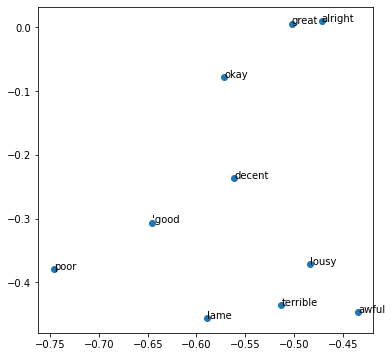

In [ ]:
_ = plot_similar_word_vectors(['good', 'bad'])

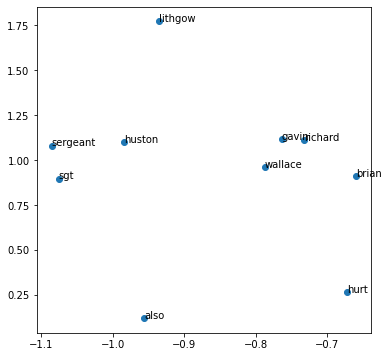

In [ ]:
_ = plot_similar_word_vectors(['john', 'william'])

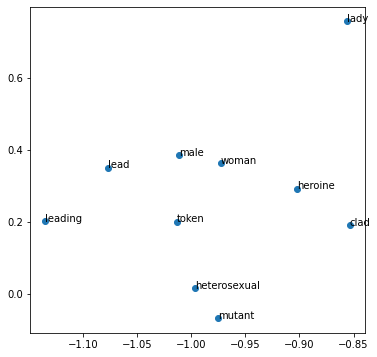

In [ ]:
_ = plot_similar_word_vectors(['men', 'female'])

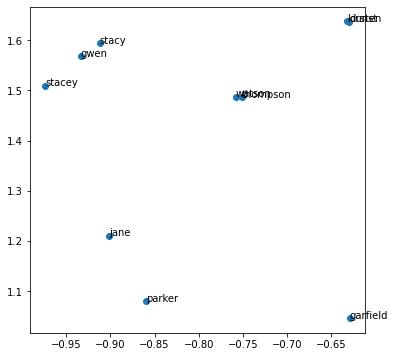

In [ ]:
_ = plot_similar_word_vectors(['mary', 'emma'])

### Topic Modelling

Reference: Gensim: Topic modelling for humans. LDA Model - gensim. (2022, May 6). Retrieved May 10, 2022, from https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html 

In [ ]:
del w2v_model, pca
gc.collect()

10301

In [ ]:
from gensim.corpora import Dictionary
word_dict = Dictionary(rev_words)
word_dict.filter_extremes(no_below=0.25, no_above=0.75)
bow_corpus = [word_dict.doc2bow(doc) for doc in rev_words]
print('unique words in the dictionary: ', len(word_dict))

unique words in the dictionary:  100000


In [ ]:
word_dict[0]

'also'

In [ ]:
train_model = True

model_path = f"{base_dir}/lda.gensim"
num_topics = 10

if train_model:
  print("Training the model...")
  lda_model = models.LdaModel(corpus=bow_corpus, id2word=word_dict.id2token,
                            chunksize=2500, iterations=500,
                            alpha='auto',eta='auto',
                            num_topics=num_topics, passes=10)
  print("Done...")
  lda_model.save(model_path)

if not train_model:
  lda_model = models.LdaModel.load(model_path)

Training the model...


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Done...


In [ ]:
top_lda_topics = lda_model.top_topics(bow_corpus)
display(top_lda_topics[0])

([(0.029238934, "n't"),
  (0.016963357, 'like'),
  (0.0134007195, 'good'),
  (0.0125403255, 'one'),
  (0.011140922, 'really'),
  (0.010527171, 'film'),
  (0.01029699, 'would'),
  (0.010097064, 'time'),
  (0.009974345, 'see'),
  (0.008449843, 'character'),
  (0.007887665, 'much'),
  (0.0076564974, 'scene'),
  (0.0076169106, 'first'),
  (0.0075190137, 'get'),
  (0.007511518, 'could'),
  (0.00738229, 'even'),
  (0.0073669367, 'story'),
  (0.007132954, 'think'),
  (0.0069821663, 'thing'),
  (0.0068381038, 'make')],
 -0.9612562220486606)